<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf backup/

In [2]:
!pip install yfinance

     |████████████████████████████████| 63 kB 475 kB/s 
     |████████████████████████████████| 6.4 MB 9.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [8]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Conv2D, Conv1D
from keras.layers import Bidirectional, AveragePooling1D, Flatten, TimeDistributed, AveragePooling2D, AveragePooling2D
from keras.layers import Lambda

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [17]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2021,12,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,24324345758
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,33430376883
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,30049226299


Nuevos indicadores
- MACD
- Retrocesos de Fibonacci
- ADX


https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [18]:
price = 'Close'

#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,10,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df[price].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std()  * 2)

In [19]:
df = df.dropna()
df.head(5)

,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
Date,,,,,,,,,,,,,,,,,,,,,,,
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,7620590080,10705.520117,10400.190137,10568.620117,9575.114421,10734.775367,10524.566439,10343.562453,9936.242973,64.470589,46.401058,56.362094,61.668570,11349.850915,10061.189319,11347.026023,9453.354250,11960.129422,8424.388791
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,6690570240,10930.120117,10480.120117,10652.340104,9652.419759,10986.416977,10700.045304,10486.829671,10036.466020,81.890759,59.751751,53.028435,63.846721,11744.414801,10115.825433,11645.556249,9314.683985,11930.456087,8790.035124
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,6084149760,11087.520117,10630.880078,10679.000065,9741.814746,11161.811188,10847.782450,10615.050913,10131.700445,86.909141,71.939978,58.448319,67.107334,12002.209001,10172.831234,11907.861278,9353.898878,11986.880283,8992.213857
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,6468539904,11322.600000,10758.100098,10747.100065,9821.761068,11298.974060,10979.694696,10734.832024,10224.706855,82.400668,69.876035,53.429560,64.462072,11888.947539,10756.252461,12138.371032,9377.829163,11920.132800,9356.460364
2018-03-06,11500.099609,11500.099609,10694.299805,10779.900391,6832169984,11288.380078,10854.783105,10717.406771,9905.190755,11125.949504,10943.368459,10740.465570,10260.525793,51.182252,63.789374,44.517045,61.343868,11974.915456,10601.844700,12065.935098,9643.631113,11866.421786,9538.698429


In [20]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1401, 23)

In [43]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [44]:
past_t = 30
forecast_t = 1
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1371, 30, 23)
Shape y --> (1371, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,56907.964844,59041.683594,56553.082031,57229.828125,3.685820e+10,56821.071094,56508.858984,57263.065885,60495.669531,56963.426592,57212.850553,57806.507124,58783.555159,54.765353,44.988193,42.906067,36.962634,59140.324530,54501.817657,59201.690510,53816.027459,65419.022744,52256.718662
1,57217.371094,57349.234375,55895.132812,56477.816406,3.237997e+10,57153.618750,56527.711719,57003.719531,60270.716667,56801.556530,57079.207981,57640.420784,58634.797820,45.900601,50.709712,48.806063,36.105806,58112.687451,56194.550049,59216.347646,53839.075791,64611.035194,52296.893712
2,56509.164062,57482.167969,52496.585938,53598.246094,3.978913e+10,56423.576562,56130.628906,56780.793490,59958.323307,55733.786385,56446.305819,57135.148948,58309.858999,50.160112,36.658726,39.309781,33.794104,59723.074285,53124.078840,59270.714006,52990.543806,63742.290697,52078.510084
3,53727.878906,53904.679688,42874.617188,49200.703125,6.138568e+10,54702.403906,55422.656641,56186.201823,59549.939063,53556.091965,55128.923511,56143.343220,57722.171523,26.696405,30.323869,28.102177,29.173716,61509.146772,47895.661040,60804.704472,50040.608810,63027.952650,51166.234459
4,49201.519531,49768.148438,47857.496094,49368.847656,3.719820e+10,53175.088281,54632.073438,55497.645312,59158.044792,52160.343862,54081.636992,55296.531275,57183.247403,9.719495,26.970435,29.796559,27.534601,60778.455684,45571.720878,61031.479079,48232.667796,62457.401671,50317.883095
5,49413.480469,50929.519531,47281.035156,50582.625000,3.770731e+10,51845.647656,54333.359375,54954.455208,58793.216276,51634.437575,53445.452994,54707.292990,56757.400796,15.391275,39.821233,36.995428,31.534222,58110.955682,45580.339631,61213.931609,47452.787141,62231.103237,49586.319420
6,50581.828125,51934.781250,50175.808594,50700.085938,3.367681e+10,50690.101562,53921.860156,54581.841667,58372.319531,51322.987029,52946.295347,54206.392109,56366.606289,17.674572,34.810526,33.471057,35.149208,54216.143976,47164.059149,61157.433510,46686.286802,61790.367921,49060.262157
7,50667.648438,51171.375000,48765.988281,50504.796875,2.847970e+10,50071.411719,53247.494141,54110.889844,57803.585156,51050.256978,52502.386534,53743.692704,55988.425037,15.419726,20.180453,35.330103,34.512539,51519.210981,48623.612457,60361.105614,46133.882667,61788.542231,48418.353863
8,50450.082031,50797.164062,47358.351562,47672.121094,2.960358e+10,49765.695312,52234.049609,53537.002865,57160.261589,49924.211683,51624.156454,52984.746253,55451.889298,12.701832,12.691674,27.693089,35.167682,52340.044191,47191.346434,59348.565286,45119.533933,61878.513995,47283.636396
9,47642.144531,50015.253906,47023.699219,47243.304688,3.096601e+10,49340.586719,51257.837500,52868.244531,56568.530729,49030.576018,50827.637951,52267.066057,54922.303194,16.029824,13.049398,32.664982,32.170487,52794.374779,45886.798658,58137.706795,44377.968205,61537.620083,46379.141245


In [45]:
test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1171, 30, 23)
Shape y_train --> (1171, 1)
Shape X_test  --> (200, 30, 23)
Shape y_test  --> (200, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,2.587439,2.534502,2.484202,2.362337,1.502087,2.638562,2.905549,2.992381,3.085096,2.619293,2.797580,2.900097,3.106432,-1.715495,-1.464619,-1.179151,-0.411461,2.869664,2.358617,3.094733,2.650570,2.916330,3.133757
1,2.363783,2.471051,2.284026,2.340692,1.717871,2.492097,2.834118,2.937543,3.047743,2.531554,2.721243,2.837908,3.067047,-1.708023,-1.424534,-1.127022,-0.360487,2.461715,2.519611,3.090108,2.495751,2.952071,3.019797
2,2.342354,2.257401,2.153871,2.132983,2.197221,2.411880,2.734818,2.874404,3.005374,2.403476,2.620562,2.756998,3.016105,-1.723010,-1.750616,-1.357926,-0.995482,2.516289,2.281413,3.067941,2.300275,3.002535,2.851909
3,2.133733,2.201437,2.165770,2.088281,1.370780,2.314602,2.620604,2.805491,2.972493,2.303116,2.529960,2.680501,2.965415,-1.940072,-2.072990,-1.184298,-1.134147,2.449255,2.148948,2.959680,2.179283,3.040411,2.697669
4,2.095036,2.045066,1.299606,1.667889,4.469259,2.130557,2.468049,2.726740,2.926231,2.095375,2.378467,2.559943,2.889459,-1.916760,-2.156986,-2.044496,-1.402205,2.428130,1.774239,2.889589,1.924188,3.131577,2.430567
5,1.653880,1.970332,1.623435,1.936928,2.787958,2.045132,2.359708,2.646493,2.887460,2.047011,2.304030,2.488772,2.836666,-1.188918,-1.492947,-1.471188,-1.005147,2.294201,1.746036,2.744456,1.862665,3.125535,2.293130
6,1.927730,1.950267,1.517138,1.689400,2.512850,1.914347,2.220303,2.554429,2.846438,1.931844,2.197574,2.394924,2.770478,-1.377073,-1.720213,-1.719293,-1.527742,2.112763,1.675145,2.529602,1.818771,3.129231,2.111809
7,1.697870,1.719739,1.648121,1.705907,1.423322,1.828587,2.136848,2.458855,2.811287,1.860596,2.113511,2.314912,2.709680,-1.196414,-1.413562,-1.876522,-1.512962,1.975503,1.650125,2.469239,1.706848,3.120110,1.960325
8,1.709300,1.682353,1.340062,1.509050,2.354667,1.712272,2.029451,2.342963,2.770952,1.747149,2.008506,2.219793,2.639442,-1.313360,-1.624772,-1.933916,-1.568666,1.806334,1.596242,2.381477,1.575467,3.107275,1.785288
9,1.507574,1.789018,1.586410,1.789128,1.864104,1.736618,1.949153,2.248804,2.742919,1.765346,1.974135,2.172288,2.592746,-0.589361,-1.094097,-1.398734,-1.274546,1.834140,1.616446,2.199809,1.622842,3.086162,1.688601


In [46]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [47]:
from tensorflow.keras.optimizers import Adam, Adadelta # - Works 
from tensorflow.keras import layers
from tensorflow.keras import activations

In [70]:
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN - 1
cnn1 = layers.Conv1D(128, 1, padding="same", activation="relu", strides=1)(inputs)
cnn1 = layers.BatchNormalization()(cnn1)
cnn1 = layers.Conv1D(128, 7, padding="same", strides=1)(cnn1)
cnn1 = layers.BatchNormalization()(cnn1)
rnn1 = layers.GRU(128, return_sequences=True)(cnn1)

# CNN - 2
cnn2 = layers.Conv1D(128, 1, padding="same", activation="relu", strides=1)(inputs)
cnn2 = layers.BatchNormalization()(cnn2)
cnn2 = layers.Conv1D(128, 5, padding="same", strides=1)(cnn2)
cnn2 = layers.BatchNormalization()(cnn2)
rnn2 = layers.GRU(128, return_sequences=True)(cnn2)

# CNN - 3
cnn3 = layers.Conv1D(128, 1, padding="same", activation="relu", strides=1)(inputs)
cnn3 = layers.BatchNormalization()(cnn3)
cnn3 = layers.Conv1D(128, 3, padding="same", strides=1)(cnn3)
cnn3 = layers.BatchNormalization()(cnn3)
rnn3 = layers.GRU(128, return_sequences=True)(cnn3)

# CNN - 4
cnn4 = layers.Conv1D(128, 1, padding="same", activation="relu", strides=1)(inputs)
cnn4 = layers.BatchNormalization()(cnn4)
rnn4 = layers.GRU(128, return_sequences=True)(cnn4)

x_1 = layers.Multiply()([rnn1, rnn2, rnn3, rnn4])
x_1 = layers.Activation(activations.relu)(x_1)

#x_2 = layers.AveragePooling1D(pool_size=2, strides=2)(x_1)
x = layers.Flatten()(x_1)

# FNN
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.4)(x)

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x)

model = tf.keras.Model(inputs, predictions)
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 30, 23)]     0           []                               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 30, 128)      3072        ['input_9[0][0]']                
                                                                                                  
 conv1d_51 (Conv1D)             (None, 30, 128)      3072        ['input_9[0][0]']                
                                                                                                  
 conv1d_53 (Conv1D)             (None, 30, 128)      3072        ['input_9[0][0]']                
                                                                                            

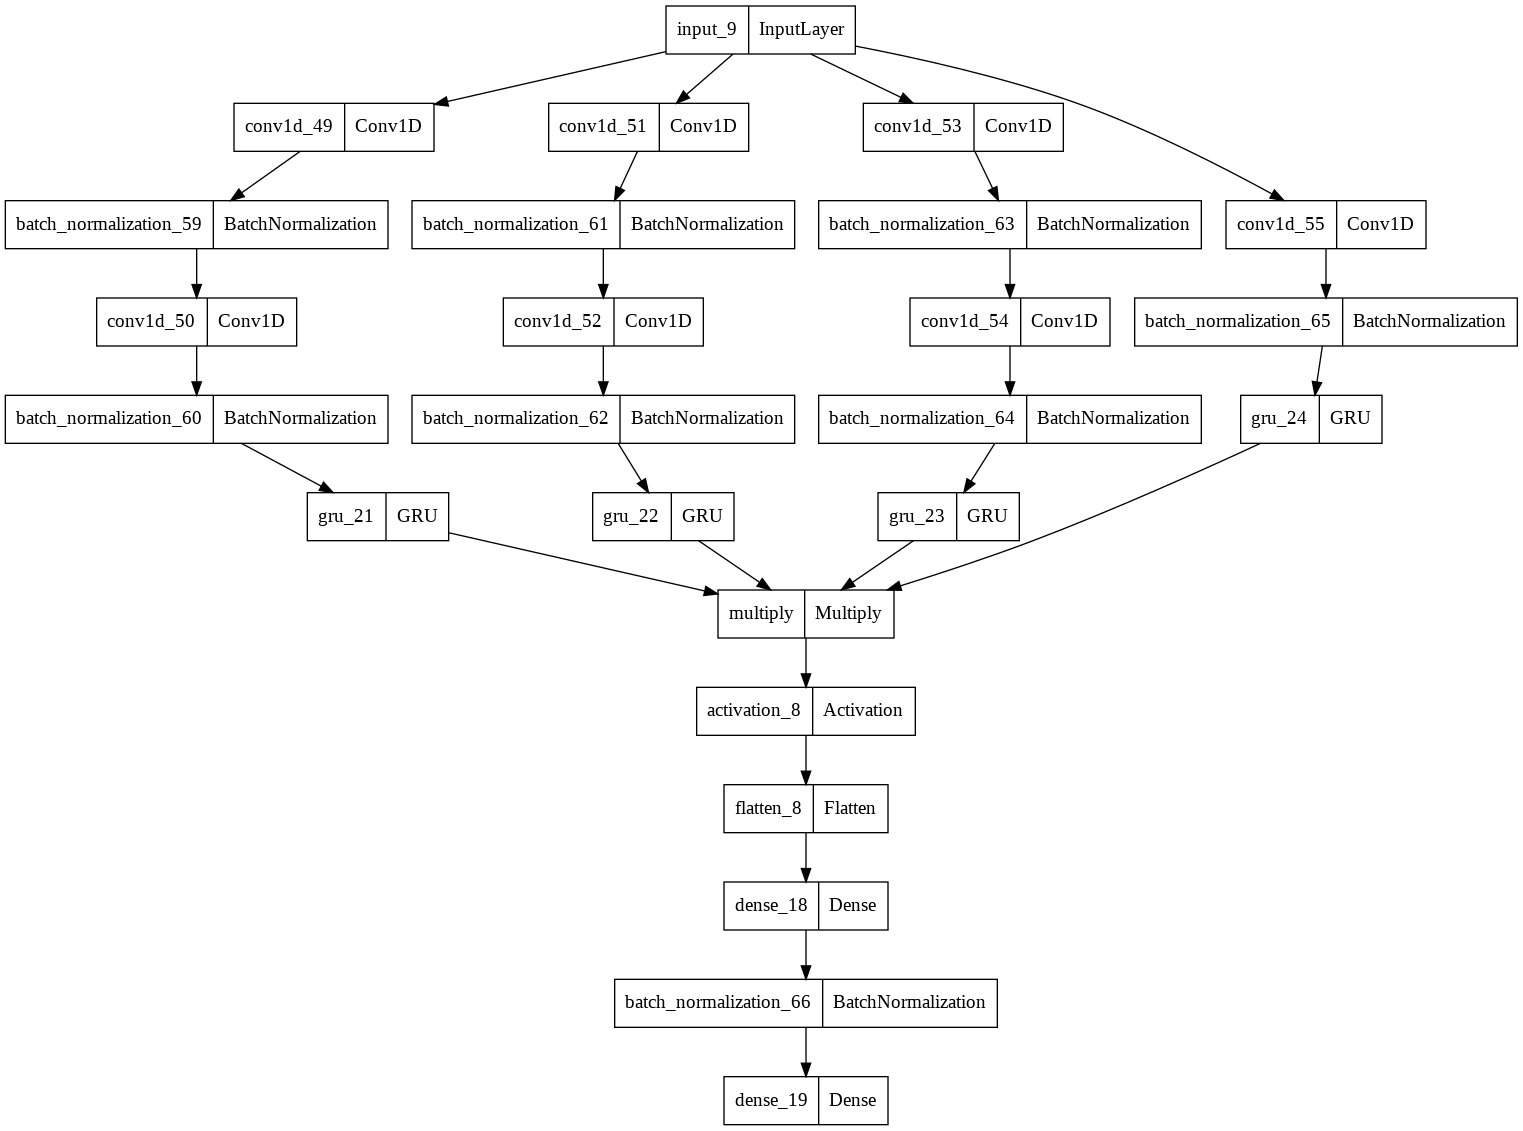

In [71]:
tf.keras.utils.plot_model(model, to_file="model.png")

In [72]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1, factor=0.5, min_lr=5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('backup/modelo_prueba{epoch:08d}.h5', save_freq = 10) 

In [73]:
history = model.fit(X_train, y_train, epochs = 500, batch_size = 8, 
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint],
                    validation_data= (X_test, y_test))

Epoch 1/500
147/147 [==============================] - 14s 45ms/step - loss: 13725.8252 - mae: 13725.8252 - val_loss: 47821.6758 - val_mae: 47821.6758 - lr: 0.0100
Epoch 2/500
147/147 [==============================] - 5s 36ms/step - loss: 12235.2637 - mae: 12235.2637 - val_loss: 47821.6758 - val_mae: 47821.6758 - lr: 0.0100
Epoch 3/500
147/147 [==============================] - 6s 38ms/step - loss: 9653.2080 - mae: 9653.2080 - val_loss: 39524.3438 - val_mae: 39524.3438 - lr: 0.0100
Epoch 4/500
147/147 [==============================] - 5s 35ms/step - loss: 6781.8774 - mae: 6781.8774 - val_loss: 33726.9766 - val_mae: 33726.9766 - lr: 0.0100
Epoch 5/500
147/147 [==============================] - 5s 36ms/step - loss: 5848.4131 - mae: 5848.4131 - val_loss: 30380.1777 - val_mae: 30380.1777 - lr: 0.0100
Epoch 6/500
147/147 [==============================] - 5s 36ms/step - loss: 5652.0425 - mae: 5652.0425 - val_loss: 26563.1816 - val_mae: 26563.1816 - lr: 0.0100
Epoch 7/500
147/147 [========

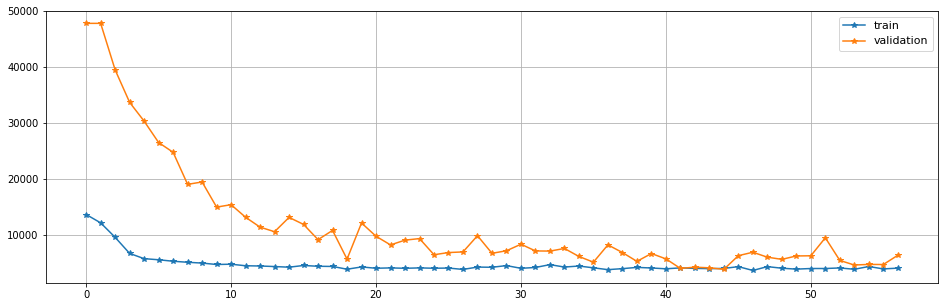

In [74]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [ ]:
y_pred_redes = model.predict(X_test, verbose=1)

7/7 [==============================] - 0s 11ms/step


In [ ]:
#y_test_original = y_test * (maximo - minimo) + minimo
#y_pred_redes_ok = y_pred_redes * (maximo - minimo) + minimo
#y_pred_baseline_ok = y_pred_baseline * (maximo - minimo) + minimo

y_test_original = y_test 
y_pred_redes_ok = y_pred_redes 
#y_pred_baseline_ok = y_pred_baseline 

In [ ]:
errores_redes = np.empty([len(y_test_original)])
#errores_baseline = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred_redes_ok[i], np.inf)
    #errores_baseline[i] = np.linalg.norm(y_test_original[i] - y_pred_baseline_ok[i], np.inf)

In [ ]:
print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))
# print("Errores usando Baseline")
# print(pd.DataFrame(errores_baseline).describe().transpose().round(2))

Errores usando Redes
   count    mean      std    min      25%      50%      75%       max
0  200.0  7471.9  3310.08  91.95  5312.82  7324.65  8974.16  17013.85


In [ ]:
#s1 = errores_baseline[errores_baseline < np.percentile(errores_baseline, 95)]
s2 = errores_redes[errores_redes < np.percentile(errores_redes, 95)]

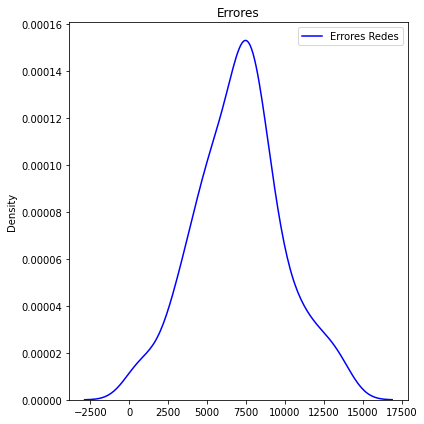

In [ ]:
plt.figure(figsize=(6,6))
#sns.kdeplot(s1, color = "red",  label = 'Errores Baseline')
sns.kdeplot(s2, color = "blue", label = 'Errores Redes')
plt.title('Errores')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# best_baseline = np.argmin(errores_baseline)
# worse_baseline = np.argmax(errores_baseline)
# print("Posicion mejor Baseline Model: " + str(best_baseline))
# print("Posicion peor Baseline Model: " + str(worse_baseline))

best_redes = np.argmin(errores_redes)
worse_redes = np.argmax(errores_redes)
print("Posicion mejor Redes Model: " + str(best_redes))
print("Posicion peor Redes Model: " + str(worse_redes))

Posicion mejor Redes Model: 5
Posicion peor Redes Model: 83


<Figure size 1440x432 with 0 Axes>

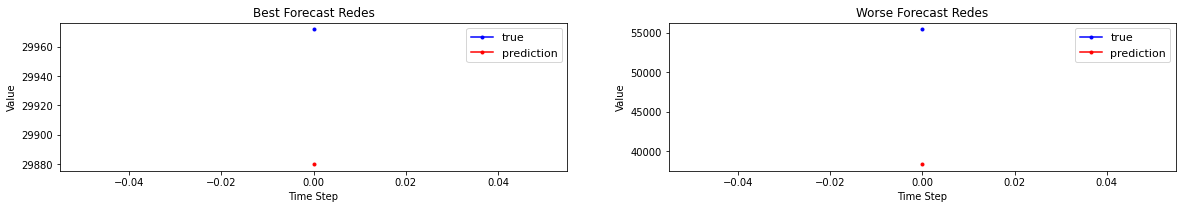

In [ ]:
plt.figure(figsize=(20, 6))
#plt.subplot(111)
# plt.title("Best Forecast Baseline")
# plt.plot(y_test[best_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[best_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

# plt.subplot(222)
# plt.title("Worse Forecast Baseline")
# plt.plot(y_test[worse_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[worse_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Redes")
plt.plot(y_test[best_redes],  color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[best_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Redes")
plt.plot(y_test[worse_redes], color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[worse_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();